In [2]:
! nvidia-smi

Sun Oct 26 10:25:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# !pip -q install "transformers==4.41.1" "huggingface_hub==0.23.2" accelerate timm safetensors --upgrade


# CLIPSEG model

In [ ]:

from PIL import Image
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

In [45]:

model_id = "CIDAS/clipseg-rd64-refined"

processor = CLIPSegProcessor.from_pretrained(model_id, trust_remote_code=True, ignore_mismatched_sizes=True)
model = CLIPSegForImageSegmentation.from_pretrained(model_id, trust_remote_code=True, ignore_mismatched_sizes=True)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [46]:
def summarize_clipseg(model, max_show=30):
    print("\n=== PARAM SUMMARY ===")
    total = 0; trainable = 0
    for n,p in model.named_parameters():
        total += p.numel()
        if p.requires_grad: trainable += p.numel()
    print(f"Total params: {total/1e6:.2f}M | Trainable: {trainable/1e6:.2f}M")

    print("\n=== TOP-LEVEL MODULES ===")
    tops = set(n.split('.')[0] for n,_ in model.named_parameters())
    print(sorted(list(tops)))  # expect ['clip','decoder']

    print("\n=== COUNTS BY PREFIX ===")
    buckets = {}
    for n,_ in model.named_parameters():
        pref = '.'.join(n.split('.')[:3])  # e.g. clip.vision_model.encoder
        buckets[pref] = buckets.get(pref, 0) + 1
    for k,v in sorted(buckets.items()):
        print(f"{k:40s} -> {v:5d} tensors")


summarize_clipseg(model)


=== PARAM SUMMARY ===
Total params: 150.75M | Trainable: 150.75M

=== TOP-LEVEL MODULES ===
['clip', 'decoder']

=== COUNTS BY PREFIX ===
clip.logit_scale                         ->     1 tensors
clip.text_model.embeddings               ->     2 tensors
clip.text_model.encoder                  ->   192 tensors
clip.text_model.final_layer_norm         ->     2 tensors
clip.text_projection.weight              ->     1 tensors
clip.vision_model.embeddings             ->     3 tensors
clip.vision_model.encoder                ->   192 tensors
clip.vision_model.post_layernorm         ->     2 tensors
clip.vision_model.pre_layrnorm           ->     2 tensors
clip.visual_projection.weight            ->     1 tensors
decoder.film_add.bias                    ->     1 tensors
decoder.film_add.weight                  ->     1 tensors
decoder.film_mul.bias                    ->     1 tensors
decoder.film_mul.weight                  ->     1 tensors
decoder.layers.0                         ->    16

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'


### Step 0 — Data Augmentation done in Roboflow, while extracting dataset

# Step 1️⃣ — Dataset Class with multiple prompts per category


In [48]:
import os, random, numpy as np, torch
from PIL import Image
from torch.utils.data import Dataset, ConcatDataset
from pycocotools.coco import COCO

class COCOPromptSegDataset(Dataset):
    def __init__(self, image_dir, ann_path, prompt_list):
        self.image_dir = image_dir
        self.coco = COCO(ann_path)
        self.img_ids = self.coco.getImgIds()
        self.prompt_list = prompt_list

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, info["file_name"])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        H, W = info["height"], info["width"]
        mask = np.zeros((H, W), dtype=np.uint8)
        for ann in anns:
            if "segmentation" in ann and ann["segmentation"]:
                mask = np.maximum(mask, self.coco.annToMask(ann).astype(np.uint8))

        mask = torch.from_numpy(mask).float()   # (H, W)
        prompt = random.choice(self.prompt_list)
        return image, prompt, mask, img_id


# Step 2️⃣ — Define prompt variants


In [49]:
crack_prompts  = ["segment crack", "segment wall crack", "segment concrete crack", "segment crack on wall"]
taping_prompts = ["segment taping area", "segment drywall seam", "segment joint tape", "segment tape"]


# Step 3️⃣ — Define paths


In [50]:
crack_train_img = "/kaggle/input/detect-cracks/cracks.v1i.coco/train"
crack_train_json = "/kaggle/input/detect-cracks/cracks.v1i.coco/train/_annotations.coco.json"
crack_val_img   = "/kaggle/input/detect-cracks/cracks.v1i.coco/valid"
crack_val_json  = "/kaggle/input/detect-cracks/cracks.v1i.coco/valid/_annotations.coco.json"

taping_train_img = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/train"
taping_train_json = "/kaggle/input/refined-json-files/taping_segment_train_annotations.coco_refined.json"
taping_val_img   = "/kaggle/input/detect-cracks/Drywall-Join-Detect.v2i.coco/valid"
taping_val_json  = "/kaggle/input/refined-json-files/taping_segment_val_annotations.coco_refined.json"


# Step 4️⃣ — Build train / val datasets


In [51]:
ds_crack_train  = COCOPromptSegDataset(crack_train_img,  crack_train_json,  crack_prompts)
ds_crack_val    = COCOPromptSegDataset(crack_val_img,    crack_val_json,    crack_prompts)
ds_taping_train = COCOPromptSegDataset(taping_train_img, taping_train_json, taping_prompts)
ds_taping_val   = COCOPromptSegDataset(taping_val_img,   taping_val_json,   taping_prompts)

from torch.utils.data import ConcatDataset
train_ds = ConcatDataset([ds_crack_train, ds_taping_train])
val_ds   = ConcatDataset([ds_crack_val,   ds_taping_val])


loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


# Step 5️⃣ — Simple collate function for CLIPSeg


In [52]:
from torch.utils.data import DataLoader

def collate_simple(batch):
    images, prompts, masks, img_ids = zip(*batch)
    return list(images), list(prompts), torch.stack(masks, dim=0), list(img_ids)

train_loader = DataLoader(train_ds, batch_size=6, shuffle=True, num_workers=2, collate_fn=collate_simple)
val_loader   = DataLoader(val_ds,   batch_size=6, shuffle=False, num_workers=2, collate_fn=collate_simple)


# Step 6: Training loop for CLIPSeg fine-tune


#### Helper Functions

In [53]:
import torch, torch.nn.functional as F
from tqdm import tqdm

# ---------- Losses ----------
def dice_loss(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum((1,2))
    union = pred.sum((1,2)) + target.sum((1,2))
    dice = 1 - (2*inter + eps) / (union + eps)
    return dice.mean()

def total_loss(logits, target):
    bce  = F.binary_cross_entropy_with_logits(logits, target)
    dice = dice_loss(logits, target)
    return bce + dice

def focal_bce_dice_loss(logits, target, alpha=0.25, gamma=2.0, lambda_dice=1.0, eps=1e-6):
    target = target.float()

    bce = F.binary_cross_entropy_with_logits(logits, target, reduction='none')

    p = torch.sigmoid(logits)
    pt = torch.where(target > 0.5, p, 1 - p)

    focal = (alpha * (1 - pt).pow(gamma) * bce).mean()

    dice = dice_loss(logits, target, eps=eps)

    return focal + lambda_dice * dice

def freeze_backbone(model, freeze=True):
    for p in model.parameters():
        p.requires_grad = not freeze

    if freeze:
        KEEP = ("decoder", "clip.text_projection",  "clip.visual_projection")
        for n, p in model.named_parameters():
            if any(k in n.lower() for k in KEEP):
                p.requires_grad = True


def batch_mean_iou_dice(logits, targets, thresh=0.5, eps=1e-6):
    """
    logits: (B,H,W) raw logits (NOT sigmoid)
    targets: (B,H,W) float {0,1}
    """
    probs = torch.sigmoid(logits)
    preds = (probs > thresh).float()

    inter = (preds * targets).sum(dim=(1,2))
    union = (preds + targets - preds * targets).sum(dim=(1,2)).clamp_min(eps)
    iou  = (inter + eps) / union

    dice = (2*inter + eps) / (preds.sum((1,2)) + targets.sum((1,2)) + eps)

    return iou.mean().item(), dice.mean().item()



In [54]:
import torch, random, matplotlib.pyplot as plt, torch.nn.functional as F

def visualize_random_val_samples(model, val_dataset, processor, device, n_samples=3, thresh=0.5):
    """
    Plot n_samples random images from val_dataset with GT and predicted masks.
    """
    model.to(device).eval()
    idxs = random.sample(range(len(val_dataset)), n_samples)
    
    # Create a single figure with subplots for all samples
    fig, axes = plt.subplots(n_samples, 3, figsize=(10, 4 * n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, i in enumerate(idxs):
            image, prompt, mask, _ = val_dataset[i]
            # prepare single-sample input
            inputs = processor(text=[prompt], images=[image],
                               return_tensors="pt", padding=True, truncation=True).to(device)
            mask_t = torch.tensor(mask).unsqueeze(0).to(device)
            out = model(**inputs)
            logits = out.logits
            if logits.ndim == 3: logits = logits.unsqueeze(1)
            logits = F.interpolate(logits, size=mask_t.shape[-2:], mode="bilinear",
                                   align_corners=False).squeeze(1)
            pred = (torch.sigmoid(logits) > thresh).float().cpu().squeeze(0)
            
            # --- visualize in row idx ---
            axes[idx, 0].imshow(image)
            axes[idx, 0].axis("off")
            axes[idx, 0].set_title("Image")
            
            axes[idx, 1].imshow(mask, cmap="gray")
            axes[idx, 1].axis("off")
            axes[idx, 1].set_title("GT Mask")
            
            axes[idx, 2].imshow(image)
            axes[idx, 2].imshow(pred, cmap="Blues", alpha=0.4)
            axes[idx, 2].axis("off")
            axes[idx, 2].set_title(f"Pred: {prompt}")
    
    plt.tight_layout()
    plt.show()

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None

epochs_warm, epochs_finetune = 5, 35


freeze_backbone(model, freeze=True)
trainable_params = [p for p in model.parameters() if p.requires_grad]
assert len(trainable_params) > 0, "No trainable params after freezing – adjust KEEP list above."
optimizer = torch.optim.AdamW(trainable_params, lr=5e-4, weight_decay=1e-4)

processor.image_processor.size = {"height": 576, "width": 576}



/tmp/ipykernel_114/3528799358.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None


In [ ]:
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
# from torch.optim.lr_scheduler import CosineAnnealingLR


# # Initialize metrics storage
# train_losses = []
# val_losses = []
# val_mious = []
# val_dices = []
# epochs_list = []

→ Unfroze encoders for fine-tuning


Epoch 1/35:   0%|          | 0/1858 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_114/247949091.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):
Epoch 1/35:  54%|█████▍    | 1000/1858 [10:01<08:37,  1.66it/s]

  Batch 1000/1858


Epoch 1/35: 100%|██████████| 1858/1858 [18:37<00:00,  1.66it/s]


Epoch 1/35 | Train loss: 0.3358


Validation Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 1: 100%|██████████| 68/68 [01:10<00:00,  1.03s/it]
Unused or unrecognized kwargs: truncation, padding.
/tmp/ipykernel_114/1531635077.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Val Loss: 0.4721 | Val mIoU: 0.4451 | Val Dice: 0.5862
--------------------------------------------------------------------------------


Unused or unrecognized kwargs: truncation, padding.
Unused or unrecognized kwargs: truncation, padding.


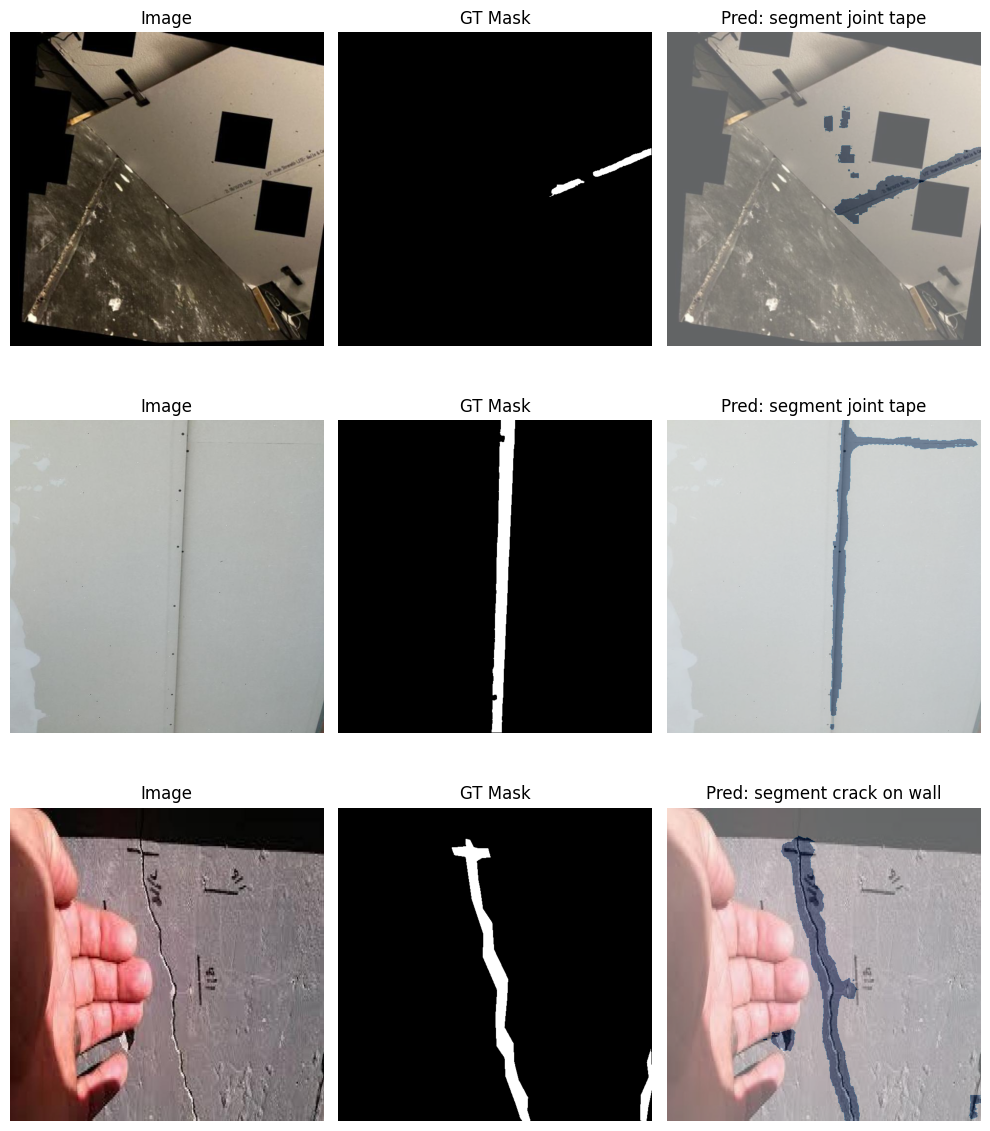

Epoch 2/35:   0%|          | 0/1858 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 2/35:  20%|██        | 379/1858 [03:47<14:46,  1.67it/s]

In [ ]:


for epoch in range(epochs_warm + epochs_finetune):
    # switch to full fine-tune after warm-up
    if epoch == epochs_warm:
        freeze_backbone(model, freeze=False)
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(trainable_params, lr=1e-5, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs_finetune, eta_min=5e-6)
        print("→ Unfroze encoders for fine-tuning")
    
    # ========== TRAINING ==========
    model.to(device).train()
    train_loss = 0.0
    
    # for batch_idx, (images, prompts, masks, _) in enumerate(train_loader):
    for batch_idx, (images, prompts, masks, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs_warm + epochs_finetune}")):

        if batch_idx and batch_idx % 1000 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}")
        
        text_inputs = processor.tokenizer(
            prompts, padding=True, truncation=True, return_tensors="pt"
        ).to(device)
        
        image_inputs = processor.image_processor(
            images, return_tensors="pt"
        ).to(device)
        
        inputs = {**text_inputs, **image_inputs}
        masks = masks.to(device)
        
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            out = model(**inputs)
            logits = out.logits
            if logits.ndim == 3:
                logits = logits.unsqueeze(1)
            logits = F.interpolate(
                logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            ).squeeze(1)
            # loss = total_loss(logits, masks)
            loss = focal_bce_dice_loss(logits, masks)  
        
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if epoch >= epochs_warm:
            scheduler.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs_warm + epochs_finetune} | Train loss: {avg_train_loss:.4f}")
    
    # ========== VALIDATION ==========
    model.to(device).eval()
    miou_running, mdice_running, n_batches = 0.0, 0.0, 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, prompts, masks, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
        # for images, prompts, masks, _ in val_loader:
            text_inputs = processor.tokenizer(
                prompts, padding=True, truncation=True, return_tensors="pt"
            ).to(device)
            
            image_inputs = processor.image_processor(
                images, return_tensors="pt"
            ).to(device)
            
            inputs = {**text_inputs, **image_inputs}
            masks = masks.to(device)
            
            out = model(**inputs)
            logits = out.logits
            if logits.ndim == 3:
                logits = logits.unsqueeze(1)
            logits = F.interpolate(
                logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            ).squeeze(1)

            # loss = total_loss(logits, masks)
            loss = focal_bce_dice_loss(logits, masks)
            
            val_loss += loss.item()
            
            miou, mdice = batch_mean_iou_dice(logits, masks, thresh=0.5)
            miou_running += miou
            mdice_running += mdice
            n_batches += 1
    
    avg_val_loss = val_loss / n_batches
    avg_miou = miou_running / n_batches
    avg_mdice = mdice_running / n_batches
    
    print(f"Val Loss: {avg_val_loss:.4f} | Val mIoU: {avg_miou:.4f} | Val Dice: {avg_mdice:.4f}")
    print("-" * 80)
    
    # Save metrics
    epochs_list.append(epoch + 1)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_mious.append(avg_miou)
    val_dices.append(avg_mdice)

    visualize_random_val_samples(model, val_ds, processor, device)



# Step 7: Plotting metrics


In [ ]:
# ========== PLOT ALL METRICS AT THE END ==========
print("\n" + "="*80)
print("TRAINING COMPLETE - Generating Plots")
print("="*80)

plt.figure(figsize=(16, 6))

# Plot 1: Loss comparison
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=6)
plt.plot(epochs_list, val_losses, 'r-s', label='Val Loss', linewidth=2, markersize=6)
plt.axvline(x=epochs_warm, color='green', linestyle='--', label='Fine-tune Start', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Loss Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 2: mIoU and Dice Score
plt.subplot(1, 2, 2)
plt.plot(epochs_list, val_mious, 'g-^', label='Val mIoU', linewidth=2, markersize=6)
plt.plot(epochs_list, val_dices, 'm-D', label='Val Dice', linewidth=2, markersize=6)
plt.axvline(x=epochs_warm, color='green', linestyle='--', label='Fine-tune Start', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('IoU & Dice Metrics', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

plt.tight_layout()
plt.savefig('/kaggle/working/training_summary.png', dpi=200, bbox_inches='tight')
plt.show()

# Print final metrics summary
print(f"\n{'='*80}")
print("BEST VALIDATION METRICS")
print(f"{'='*80}")
best_miou_idx = val_mious.index(max(val_mious))
best_dice_idx = val_dices.index(max(val_dices))
best_loss_idx = val_losses.index(min(val_losses))
print(f"Best mIoU:       {max(val_mious):.4f} at epoch {epochs_list[best_miou_idx]}")
print(f"Best Dice:       {max(val_dices):.4f} at epoch {epochs_list[best_dice_idx]}")
print(f"Lowest Val Loss: {min(val_losses):.4f} at epoch {epochs_list[best_loss_idx]}")
print(f"{'='*80}\n")

# Step 8: Saving Model


In [ ]:


from huggingface_hub import HfApi, login

# Login to Hugging Face (you'll need a token)
login(token=<hf_token>)



The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Upload model directly
model.push_to_hub("RaviKush/clipseg_focal_loss_v1")
processor.push_to_hub("RaviKush/clipseg_focal_loss_v1")